In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [2]:
target = pd.read_csv('dengue_labels_train.csv')
data = pd.read_csv('dengue_features_train.csv')
validate = pd.read_csv('dengue_features_test.csv')

In [3]:
#Try ARIMA on target
target['city'].unique()

array(['sj', 'iq'], dtype=object)

In [4]:
sanjuan = target[target.city == 'sj']
iquitos = target[target.city == 'iq']

In [5]:
sanjuan.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


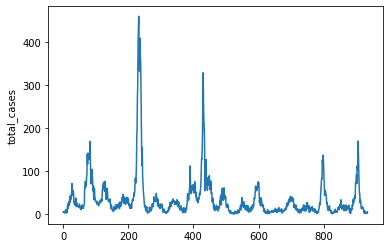

In [6]:
import seaborn as sns

#plt.subplot(1,2,1)
sns.lineplot(x = sanjuan.index,y = sanjuan.total_cases)

In [7]:
import datetime
#Convert weekofyear to date
def date_convert(data):
    data['date'] = 0
    for i in range(data.shape[0]):
        predate = str(data.loc[i, 'year']) + "-W" + str(data.loc[i, 'weekofyear'])
        data['date'][i] = datetime.datetime.strptime(predate + '-1', "%Y-W%W-%w")
        
def date_convert2(data):
    data['date'] = 0
    predate = str(data.loc[0, 'year']) + "-W" + str(data.loc[0, 'weekofyear'])
    data.loc[0, 'date'] = datetime.datetime.strptime(predate + '-1', "%Y-W%W-%w")
    for i in range(data.shape[0] - 1):
        data.loc[i+1, 'date'] = data.loc[i, 'date'] + datetime.timedelta(days =7)

In [8]:
date_convert2(sanjuan)

In [9]:
sanjuan.head()

,city,year,weekofyear,total_cases,date
0,sj,1990,18,4,1990-04-30 00:00:00
1,sj,1990,19,5,1990-05-07 00:00:00
2,sj,1990,20,4,1990-05-14 00:00:00
3,sj,1990,21,3,1990-05-21 00:00:00
4,sj,1990,22,6,1990-05-28 00:00:00


In [10]:
sj_series = sanjuan[['date', 'total_cases']].set_index('date')

Text(0, 0.5, 'Number of Cases')

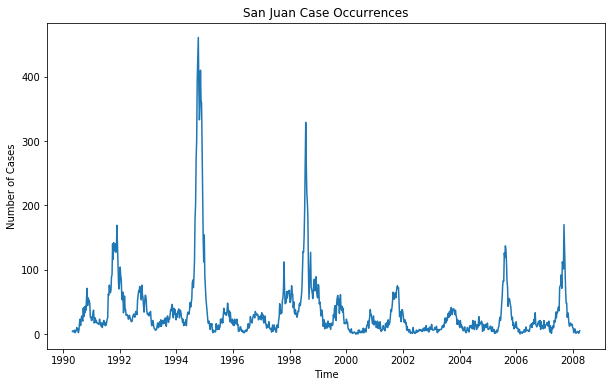

In [11]:
plt.figure(figsize = (10,6))
plt.plot(sj_series)
plt.title('San Juan Case Occurrences')
plt.xlabel('Time')
plt.ylabel('Number of Cases')

In [12]:
iquitos = iquitos.reset_index(drop = True)
date_convert2(iquitos)
iq_series = iquitos[['date', 'total_cases']].set_index('date')

Text(0, 0.5, 'Number of Cases')

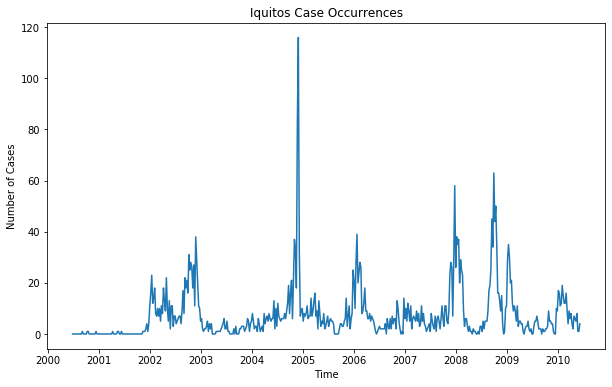

In [13]:
plt.figure(figsize=(10,6))
plt.plot(iq_series)
plt.title('Iquitos Case Occurrences')
plt.xlabel('Time')
plt.ylabel('Number of Cases')

In [14]:
# Statistical Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose as sdc

In [15]:
sj_decom = sdc(sj_series)
iq_decom = sdc(iq_series)

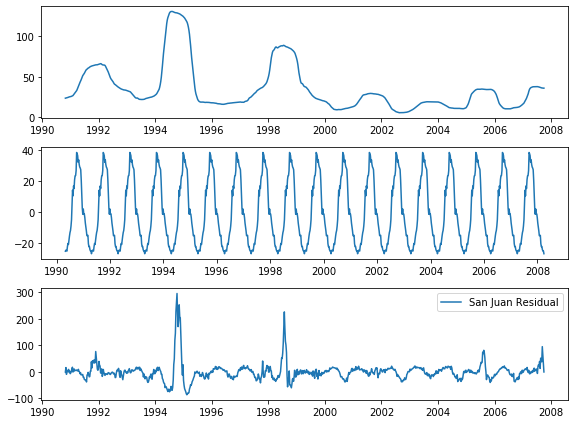

In [16]:
# Plot sj_decom
plt.figure(figsize = (8,6))
plt.subplot(311)
plt.plot(sj_decom.trend, label = 'San Juan Trend')
plt.subplot(312)
plt.plot(sj_decom.seasonal, label = 'San Juan Seasonality')
plt.subplot(313)
plt.plot(sj_decom.resid, label = 'San Juan Residual')
plt.legend(loc = 'best')
plt.tight_layout()

In [17]:
iq_arima = ARIMA(iq_series, order = (2,1,1))
sj_arima = ARIMA(sj_series, order = (2,1,1))

In [18]:
#Split the validate
sj_val = validate[validate['city'] == 'sj']
iq_val = validate[validate['city'] == 'iq']

print('Length of SJ = ', sj_val.shape[0])
print('Length of IQ = ', iq_val.shape[0])

Length of SJ =  260
Length of IQ =  156


In [19]:
iq_forecast = iq_arima.fit().forecast(steps = iq_val.shape[0])
sj_forecast = sj_arima.fit().forecast(steps = sj_val.shape[0])
iq_forecast = list(iq_forecast[0])
sj_forecast = list(sj_forecast[0])

In [20]:
total_forecast = sj_forecast.copy()
total_forecast.extend(iq_forecast)

In [21]:
submission = [int(round(x)) for x in total_forecast]

In [22]:
sub_format = pd.read_csv('submission_format.csv')

In [23]:
sub_format.total_cases = submission

In [24]:
sub_format.to_csv('out_town_split_211.csv', index = False)

# Log-transform

In [25]:
sj_log = np.log1p(sj_series)
iq_log = np.log1p(iq_series)

Text(0, 0.5, 'Log of Number of Cases')

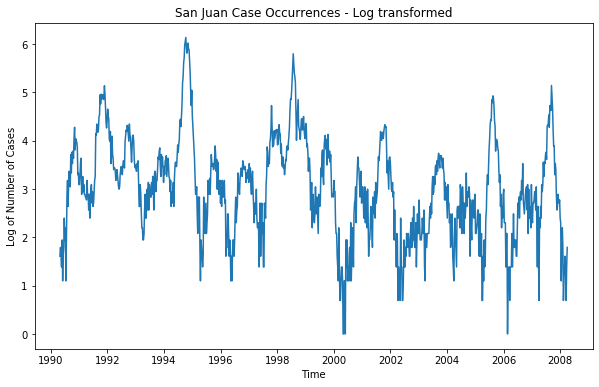

In [26]:
plt.figure(figsize = (10,6))
plt.plot(sj_log)
plt.title('San Juan Case Occurrences - Log transformed')
plt.xlabel('Time')
plt.ylabel('Log of Number of Cases')

Text(0, 0.5, 'Log of Number of Cases')

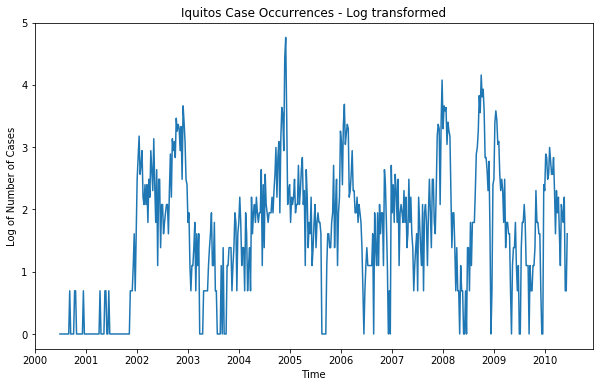

In [27]:
plt.figure(figsize=(10,6))
plt.plot(iq_log)
plt.title('Iquitos Case Occurrences - Log transformed')
plt.xlabel('Time')
plt.ylabel('Log of Number of Cases')

In [28]:
# Log Decom
log_sj_decom = sdc(sj_log)
log_iq_decom = sdc(iq_log)

Text(0.5, 0.98, 'San Juan Decomposition')

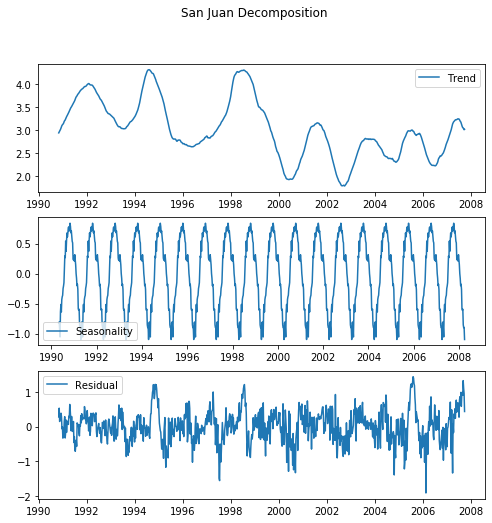

In [29]:
# Plot sj_decom
plt.figure(figsize = (8,8))
plt.subplot(311)
plt.plot(log_sj_decom.trend, label = 'Trend')
#plt.title('Trend')
plt.legend(loc = 'best')
plt.subplot(312)
plt.plot(log_sj_decom.seasonal, label = 'Seasonality')
#plt.title('Seasonality')
plt.legend(loc = 'best')
plt.subplot(313)
plt.plot(log_sj_decom.resid, label = 'Residual')
#plt.title('Residual')
plt.legend(loc = 'best')
#plt.tight_layout()
plt.suptitle('San Juan Decomposition')

Text(0.5, 0.98, 'Iquitos Decomposition')

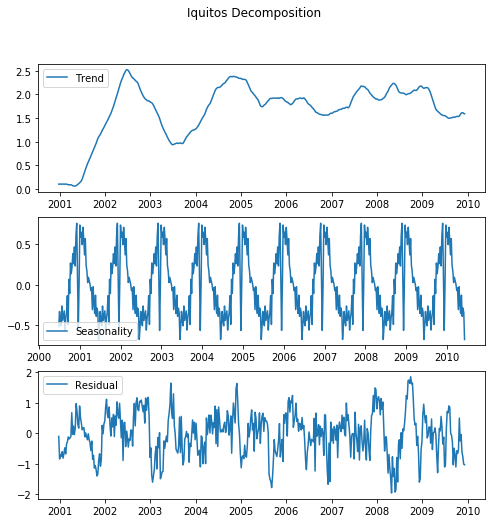

In [30]:
# Plot sj_decom
plt.figure(figsize = (8,8))
plt.subplot(311)
plt.plot(log_iq_decom.trend, label = 'Trend')
#plt.title('Trend')
plt.legend(loc = 'best')
plt.subplot(312)
plt.plot(log_iq_decom.seasonal, label = 'Seasonality')
#plt.title('Seasonality')
plt.legend(loc = 'best')
plt.subplot(313)
plt.plot(log_iq_decom.resid, label = 'Residual')
#plt.title('Residual')
plt.legend(loc = 'best')
#plt.legend(loc = 'best')
plt.suptitle('Iquitos Decomposition')
#plt.tight_layout()

In [31]:
sj_logarima = ARIMA(sj_log, order = (1,1,1))
iq_logarima = ARIMA(iq_log, order = (1,1,1))

In [32]:
sj_forelog = sj_logarima.fit().forecast(steps = sj_val.shape[0])[0]
iq_forelog = iq_logarima.fit().forecast(steps = iq_val.shape[0])[0]

In [33]:
total_log_forecast = list(sj_forelog)
total_log_forecast.extend(list(iq_forelog))

In [34]:
log_submission = [int(round(np.exp(x) - 1)) for x in total_log_forecast]

In [35]:
sub_format.total_cases = log_submission
sub_format.to_csv('log_out_town_split.csv', index = False)

# Train-Test Split

### San Jose 

Use data until 2005 as the training data, and the rest as the testing data.

In [36]:
sj_train = sj_series[sj_series.index.year < 2004]
sj_test = sj_series[sj_series.index.year > 2003]

### Iquitos 

Use data until 2008 as the training data, and the rest as the testing data.

In [37]:
iq_series_cut = iq_series[iq_series.index.year >= 2002]

iq_train = iq_series_cut[iq_series_cut.index.year < 2009]
iq_test = iq_series_cut[iq_series_cut.index.year > 2008]

# Miscellaneous

In [38]:
#Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

In [39]:
dftest = adfuller(sj_series['total_cases'], autolag = 'AIC')

In [40]:
dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-Value', '#Lags Used', 'Number of Observations Used'])

In [41]:
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

In [42]:
dfoutput

Test Statistic                -6.650078e+00
p-Value                        5.147319e-09
#Lags Used                     9.000000e+00
Number of Observations Used    9.260000e+02
Critical Value (1%)           -3.437432e+00
Critical Value (5%)           -2.864666e+00
Critical Value (10%)          -2.568435e+00
dtype: float64

In [43]:
#Log
temp_log = np.log1p(sj_series['total_cases'])
dftest = adfuller(temp_log, autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-Value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -6.160455e+00
p-Value                        7.195226e-08
#Lags Used                     1.400000e+01
Number of Observations Used    9.210000e+02
Critical Value (1%)           -3.437470e+00
Critical Value (5%)           -2.864683e+00
Critical Value (10%)          -2.568444e+00
dtype: float64

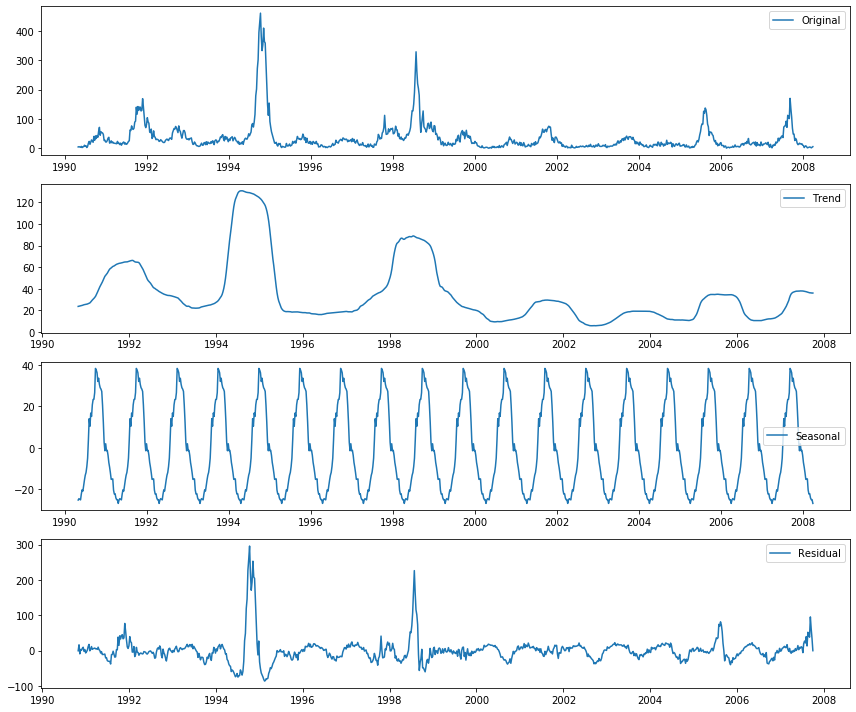

In [44]:
# Seasonal Decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decom = seasonal_decompose(sj_series['total_cases'])

trend = decom.trend
seasonal = decom.seasonal
residual = decom.resid

plt.figure(figsize = (12,10))
plt.subplot(411)
plt.plot(sj_series['total_cases'], label = "Original")
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = "Trend")
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = "Seasonal")
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = "Residual")
plt.legend(loc = 'best')
plt.tight_layout()

# ARIMA with Train Test Split

In [45]:
#use sj_train, sj_test, iq_train, iq_test

#Generate list of hyperparameters
hyperp_list = [(1,0,0), (0,0,1)]
max_p = 5
max_d = 2
max_q = 5
for i in range(1,max_p+1):
    for j in range(max_d+1):
        for k in range(1,max_q+1):
            hyperp_list.append((i,j,k))

In [46]:
'''
for param in hyperp_list:
    sj_model = ARIMA(sj_train, order = param)
    iq_model = ARIMA(iq_train, order = param)
    sj_forecast_train = sj_model.fit().forecast(steps = sj_train.shape[0])
    sj_forecast_test = sj_model.fit().forecast(steps = sj_test.shape[0])
    iq_forecast_train = iq_model.fit().forecast(steps = iq_train.shape[0])
    iq_forecast_test = iq_model.fit().forecast(steps = iq_test.shape[0])
'''

from sklearn.metrics import mean_absolute_error

def forecasting(data_train, data_test, orders = hyperp_list):
    #train_result = dict()
    test_result = dict()
    for order in orders:
        model = ARIMA(data_train, order = order)
        try:
            model_fit = model.fit()
            test_forecast = model_fit.forecast(steps = data_test.shape[0])
            test_result[order] = [int(i) for i in test_forecast[0]]
            
        except:
            print('The order of {0} is not stationary'.format(order))
    return test_result

In [47]:
sj_result = forecasting(data_train=sj_train, data_test = sj_test)

The order of (1, 1, 3) is not stationary
The order of (1, 1, 4) is not stationary
The order of (1, 1, 5) is not stationary
The order of (2, 0, 3) is not stationary
The order of (2, 0, 5) is not stationary
The order of (2, 1, 3) is not stationary
The order of (2, 1, 4) is not stationary
The order of (2, 1, 5) is not stationary
The order of (3, 0, 3) is not stationary
The order of (3, 0, 4) is not stationary
The order of (3, 0, 5) is not stationary
The order of (3, 1, 4) is not stationary
The order of (3, 1, 5) is not stationary
The order of (4, 0, 2) is not stationary
The order of (4, 0, 3) is not stationary
The order of (4, 0, 4) is not stationary
The order of (4, 0, 5) is not stationary
The order of (4, 1, 5) is not stationary
The order of (5, 0, 2) is not stationary
The order of (5, 0, 3) is not stationary
The order of (5, 0, 4) is not stationary
The order of (5, 0, 5) is not stationary


In [48]:
# Calculate Accuracy
for order in sj_result:
    print('The MAE for order {0} = {1}'.format(order, mean_absolute_error(sj_test, sj_result[order])))

The MAE for order (1, 0, 0) = 24.445945945945947
The MAE for order (0, 0, 1) = 28.12162162162162
The MAE for order (1, 0, 1) = 25.24774774774775
The MAE for order (1, 0, 2) = 25.734234234234233
The MAE for order (1, 0, 3) = 25.66216216216216
The MAE for order (1, 0, 4) = 25.87837837837838
The MAE for order (1, 0, 5) = 26.05855855855856
The MAE for order (1, 1, 1) = 15.756756756756756
The MAE for order (1, 1, 2) = 15.882882882882884
The MAE for order (1, 2, 1) = 40.792792792792795
The MAE for order (1, 2, 2) = 39.74324324324324
The MAE for order (1, 2, 3) = 39.92342342342342
The MAE for order (1, 2, 4) = 40.44144144144144
The MAE for order (1, 2, 5) = 40.66216216216216
The MAE for order (2, 0, 1) = 27.31981981981982
The MAE for order (2, 0, 2) = 27.33783783783784
The MAE for order (2, 0, 4) = 27.2972972972973
The MAE for order (2, 1, 1) = 15.837837837837839
The MAE for order (2, 1, 2) = 15.855855855855856
The MAE for order (2, 2, 1) = 40.873873873873876
The MAE for order (2, 2, 2) = 40.

In [49]:
iq_result = forecasting(data_train=iq_train, data_test = iq_test)

The order of (1, 1, 5) is not stationary
The order of (1, 2, 1) is not stationary
The order of (1, 2, 2) is not stationary
The order of (1, 2, 5) is not stationary
The order of (2, 0, 3) is not stationary
The order of (2, 0, 5) is not stationary
The order of (2, 1, 4) is not stationary
The order of (2, 1, 5) is not stationary
The order of (2, 2, 3) is not stationary
The order of (3, 0, 4) is not stationary
The order of (3, 0, 5) is not stationary
The order of (3, 1, 4) is not stationary
The order of (3, 1, 5) is not stationary
The order of (3, 2, 5) is not stationary
The order of (4, 0, 4) is not stationary
The order of (4, 0, 5) is not stationary


In [50]:
# Calculate Accuracy
for order in iq_result:
    print('The MAE for order {0} = {1}'.format(order, mean_absolute_error(iq_test, iq_result[order])))

The MAE for order (1, 0, 0) = 5.8933333333333335
The MAE for order (0, 0, 1) = 5.933333333333334
The MAE for order (1, 0, 1) = 5.8933333333333335
The MAE for order (1, 0, 2) = 5.92
The MAE for order (1, 0, 3) = 5.933333333333334
The MAE for order (1, 0, 4) = 5.92
The MAE for order (1, 0, 5) = 5.92
The MAE for order (1, 1, 1) = 6.68
The MAE for order (1, 1, 2) = 5.293333333333333
The MAE for order (1, 1, 3) = 5.413333333333333
The MAE for order (1, 1, 4) = 5.173333333333333
The MAE for order (1, 2, 3) = 6.373333333333333
The MAE for order (1, 2, 4) = 6.12
The MAE for order (2, 0, 1) = 5.92
The MAE for order (2, 0, 2) = 5.92
The MAE for order (2, 0, 4) = 5.92
The MAE for order (2, 1, 1) = 5.173333333333333
The MAE for order (2, 1, 2) = 5.413333333333333
The MAE for order (2, 1, 3) = 5.213333333333333
The MAE for order (2, 2, 1) = 6.373333333333333
The MAE for order (2, 2, 2) = 6.16
The MAE for order (2, 2, 4) = 6.013333333333334
The MAE for order (2, 2, 5) = 5.986666666666666
The MAE for

In [51]:
#For SJ use (4,1,2) and for IQ use (5,0,3)
sj_order = (4,1,2)
iq_order = (5,0,3)

sj_model = ARIMA(sj_train, order = sj_order)
iq_model = ARIMA(iq_train, order = iq_order)

sj_forecast = sj_model.fit().forecast(steps = sj_val.shape[0])[0]
iq_forecast = iq_model.fit().forecast(steps = iq_val.shape[0])[0]

In [52]:
total_forecast = list(sj_forecast)
total_forecast.extend(list(iq_forecast))
submission = [int(round(x)) for x in total_forecast]

sub_format.total_cases = submission
sub_format.to_csv('Best_ARIMA_4.csv', index = False)

In [53]:
sj_forecast[:10]

array([13.90092155, 12.60216172, 12.99861731, 12.49535378, 12.27513616,
       11.97031091, 11.90127576, 11.83001842, 11.79057739, 11.73997844])

# Trimmed Outliers

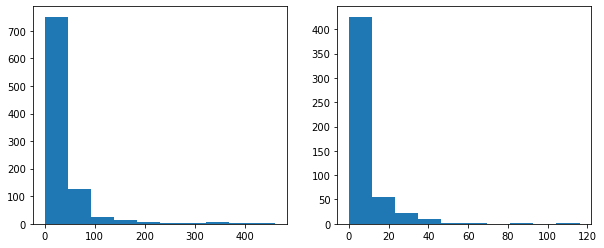

In [54]:
# Use sj_series and iq_series
fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(10)
axs[0].hist(sj_series.total_cases)
axs[1].hist(iq_series.total_cases)
plt.show()

In [55]:
sj_bound = 120
iq_bound = 30

sj_trimmed = sj_series['total_cases'].apply(lambda x: min(x, sj_bound))
iq_trimmed = iq_series['total_cases'].apply(lambda x: min(x, iq_bound))

# ARIMA (with trimmed data)

In [56]:
sj_train = sj_trimmed[sj_trimmed.index.year < 2004]
sj_test = sj_trimmed[sj_trimmed.index.year > 2003]

iq_series_cut = iq_trimmed[iq_trimmed.index.year >= 2002]
iq_train = iq_series_cut[iq_series_cut.index.year < 2009]
iq_test = iq_series_cut[iq_series_cut.index.year > 2008]

In [57]:
sj_result = forecasting(data_train=sj_train, data_test = sj_test)

The order of (1, 1, 1) is not stationary
The order of (1, 1, 2) is not stationary
The order of (1, 1, 3) is not stationary
The order of (1, 1, 4) is not stationary
The order of (1, 1, 5) is not stationary
The order of (1, 2, 1) is not stationary
The order of (1, 2, 2) is not stationary
The order of (2, 1, 3) is not stationary
The order of (2, 1, 4) is not stationary
The order of (2, 1, 5) is not stationary
The order of (3, 0, 5) is not stationary
The order of (3, 1, 4) is not stationary
The order of (3, 1, 5) is not stationary
The order of (4, 0, 3) is not stationary
The order of (4, 0, 4) is not stationary
The order of (4, 0, 5) is not stationary
The order of (4, 1, 5) is not stationary
The order of (4, 2, 4) is not stationary
The order of (5, 0, 2) is not stationary
The order of (5, 0, 3) is not stationary


In [58]:
# Calculate Accuracy
for order in sj_result:
    print('The MAE for order {0} = {1}'.format(order, mean_absolute_error(sj_test, sj_result[order])))

The MAE for order (1, 0, 0) = 21.72972972972973
The MAE for order (0, 0, 1) = 23.684684684684683
The MAE for order (1, 0, 1) = 21.545045045045047
The MAE for order (1, 0, 2) = 21.27027027027027
The MAE for order (1, 0, 3) = 21.3018018018018
The MAE for order (1, 0, 4) = 21.41891891891892
The MAE for order (1, 0, 5) = 21.382882882882882
The MAE for order (1, 2, 3) = 31.26126126126126
The MAE for order (1, 2, 4) = 31.725225225225227
The MAE for order (1, 2, 5) = 31.995495495495497
The MAE for order (2, 0, 1) = 21.39189189189189
The MAE for order (2, 0, 2) = 22.86036036036036
The MAE for order (2, 0, 3) = 22.68018018018018
The MAE for order (2, 0, 4) = 22.554054054054053
The MAE for order (2, 0, 5) = 22.45945945945946
The MAE for order (2, 1, 1) = 15.603603603603604
The MAE for order (2, 1, 2) = 15.481981981981981
The MAE for order (2, 2, 1) = 31.423423423423422
The MAE for order (2, 2, 2) = 31.16216216216216
The MAE for order (2, 2, 3) = 31.725225225225227
The MAE for order (2, 2, 4) = 3

In [59]:
iq_result = forecasting(data_train=iq_train, data_test = iq_test)

The order of (1, 1, 4) is not stationary
The order of (1, 1, 5) is not stationary
The order of (1, 2, 1) is not stationary
The order of (2, 1, 3) is not stationary
The order of (2, 1, 4) is not stationary
The order of (2, 1, 5) is not stationary
The order of (3, 1, 3) is not stationary
The order of (3, 1, 4) is not stationary
The order of (3, 1, 5) is not stationary
The order of (3, 2, 5) is not stationary
The order of (4, 1, 4) is not stationary
The order of (4, 1, 5) is not stationary
The order of (5, 0, 5) is not stationary
The order of (5, 2, 1) is not stationary
The order of (5, 2, 4) is not stationary
The order of (5, 2, 5) is not stationary


In [60]:
# Calculate Accuracy
for order in iq_result:
    print('The MAE for order {0} = {1}'.format(order, mean_absolute_error(iq_test, iq_result[order])))

The MAE for order (1, 0, 0) = 5.4
The MAE for order (0, 0, 1) = 5.493333333333333
The MAE for order (1, 0, 1) = 5.386666666666667
The MAE for order (1, 0, 2) = 5.386666666666667
The MAE for order (1, 0, 3) = 5.426666666666667
The MAE for order (1, 0, 4) = 5.426666666666667
The MAE for order (1, 0, 5) = 5.426666666666667
The MAE for order (1, 1, 1) = 5.386666666666667
The MAE for order (1, 1, 2) = 5.493333333333333
The MAE for order (1, 1, 3) = 5.826666666666667
The MAE for order (1, 2, 2) = 7.493333333333333
The MAE for order (1, 2, 3) = 6.826666666666667
The MAE for order (1, 2, 4) = 9.346666666666666
The MAE for order (1, 2, 5) = 7.8933333333333335
The MAE for order (2, 0, 1) = 5.373333333333333
The MAE for order (2, 0, 2) = 5.466666666666667
The MAE for order (2, 0, 3) = 5.413333333333333
The MAE for order (2, 0, 4) = 5.413333333333333
The MAE for order (2, 0, 5) = 5.426666666666667
The MAE for order (2, 1, 1) = 5.44
The MAE for order (2, 1, 2) = 5.8133333333333335
The MAE for order

In [61]:
# (4,1,2) for San Juan, and (3,1,1) for Iquitos
sj_order = (5,1,5)
iq_order = (1,0,0)

sj_model = ARIMA(sj_trimmed, order = sj_order)
iq_model = ARIMA(iq_trimmed, order = iq_order)

sj_forecast = sj_model.fit().forecast(steps = sj_val.shape[0])[0]
iq_forecast = iq_model.fit().forecast(steps = iq_val.shape[0])[0]

In [62]:
total_forecast = list(sj_forecast)
total_forecast.extend(list(iq_forecast))
submission = [int(round(x)) for x in total_forecast]

sub_format.total_cases = submission
sub_format.to_csv('ARIMA_trimmed.csv', index = False)

# Linear SVR

In [63]:
from sklearn.svm import SVR

In [64]:
svr = SVR(kernel = 'linear')
svr_fit = svr.fit(x_trimmed, )